In [1]:
%load_ext autoreload
%autoreload 2

# How do mutations affect genetic circuits on a population scale?

In [2]:
from functools import partial
import os
import sys
import numpy as np
import jax
import jax.numpy as jnp
import diffrax as dfx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pink_palette = sns.cubehelix_palette(rot=0.5, start=2.7, gamma=1.1)

jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


from synbio_morpher.utils.results.analytics.naming import get_analytics_types_all, get_true_names_analytics, get_true_interaction_cols
from explanations.data_enhancing import enhance_data, proc_info, melt, summ

In [3]:
og_dir = '../data/generate_seqs_flexible/2023_04_17_205800/'

fn_og = os.path.join(og_dir, 'circuit_stats.csv')
mut_dir = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/mutation_effect_on_interactions_signal'
fn_mut = '../data/ensemble_mutation_effect_analysis/2023_05_16_174613/summarise_simulation/tabulated_mutation_info.csv'
fn_random_start = '../data/ensemble_mutation_effect_analysis/2023_06_05_164913/summarise_simulation/tabulated_mutation_info.csv'

data = pd.read_csv(fn_mut)
data_rnd = pd.read_csv(fn_random_start)

In [4]:
data, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data)
data_rnd, num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols = proc_info(data_rnd)


/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/wadh6511/Kode/synbio_morpher/explanations/data_enhancing.py:76: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  mutation_log = grouped[numerical_cols].apply(
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarni

In [5]:
# Mutation stats

good_cols = list(data.columns)
[good_cols.remove(x) for x in get_true_interaction_cols(data, 'binding_rates_dissociation') + get_true_interaction_cols(data, 'eqconstants') +
get_true_interaction_cols(data, 'energies') + get_true_interaction_cols(data, 'binding_sites') + num_group_cols + num_bs_cols]
# interaction = 'energies'
dfm = melt(data[data['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)
dfm_rnd = melt(data_rnd[data_rnd['sample_name'] == 'RNA_0'], num_group_cols, num_bs_cols, numerical_cols, key_cols, mutation_log, bs_range_cols)

# dfm_rnd
# dfm = data[data['sample_name'] == 'RNA_0'].melt(good_cols, value_vars=get_true_interaction_cols(
#     data, interaction), var_name='idx', value_name=interaction)

/home/wadh6511/Kode/synbio_morpher/explanations/data_enhancing.py:128: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  infom[f'{k}_diffs'] = info.groupby(['circuit_name'])[get_true_interaction_cols2(info, k)].apply(
/home/wadh6511/Kode/synbio_morpher/explanations/data_enhancing.py:128: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>

### The problem

Text(0.5, 0, 'Sensitivity')

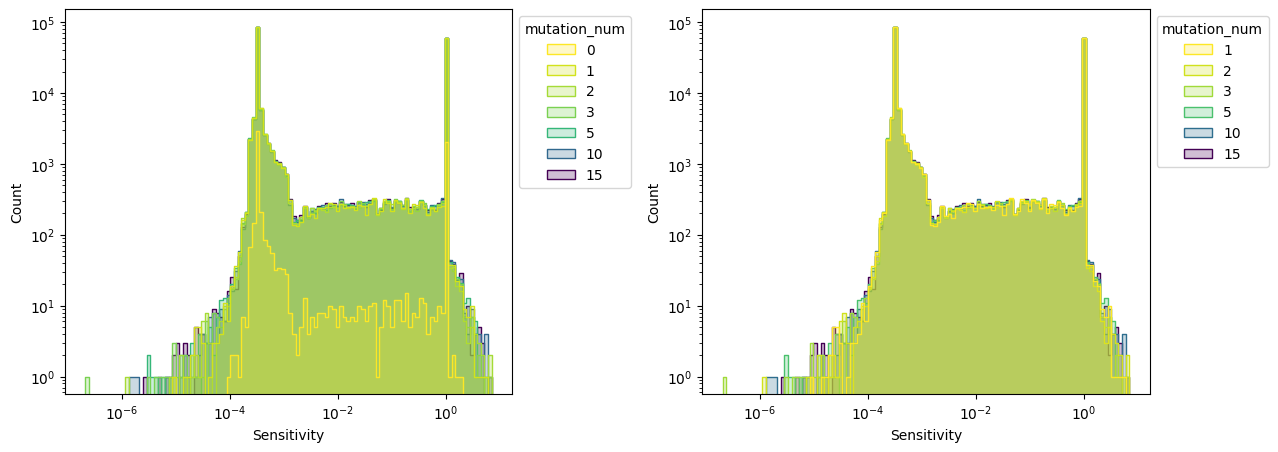

In [6]:
fig = plt.figure(figsize=(14, 5))
fig.subplots_adjust(hspace=0.125, wspace=0.425)
ax = plt.subplot(1,2,1) 
sns.histplot(data_rnd, x='sensitivity_wrt_species-6', hue='mutation_num', element='step', log_scale=[True, True], palette='viridis_r')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Sensitivity')

ax = plt.subplot(1,2,2) 
sns.histplot(data_rnd[data_rnd['mutation_num'] != 0], x='sensitivity_wrt_species-6', hue='mutation_num', element='step', log_scale=[True, True], palette='viridis_r')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Sensitivity')



/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/wadh6511/Kode/env_circuits/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0.98, 'CDF of Sensitivity - Unbiased reference circuits\nNot including RNA_0')

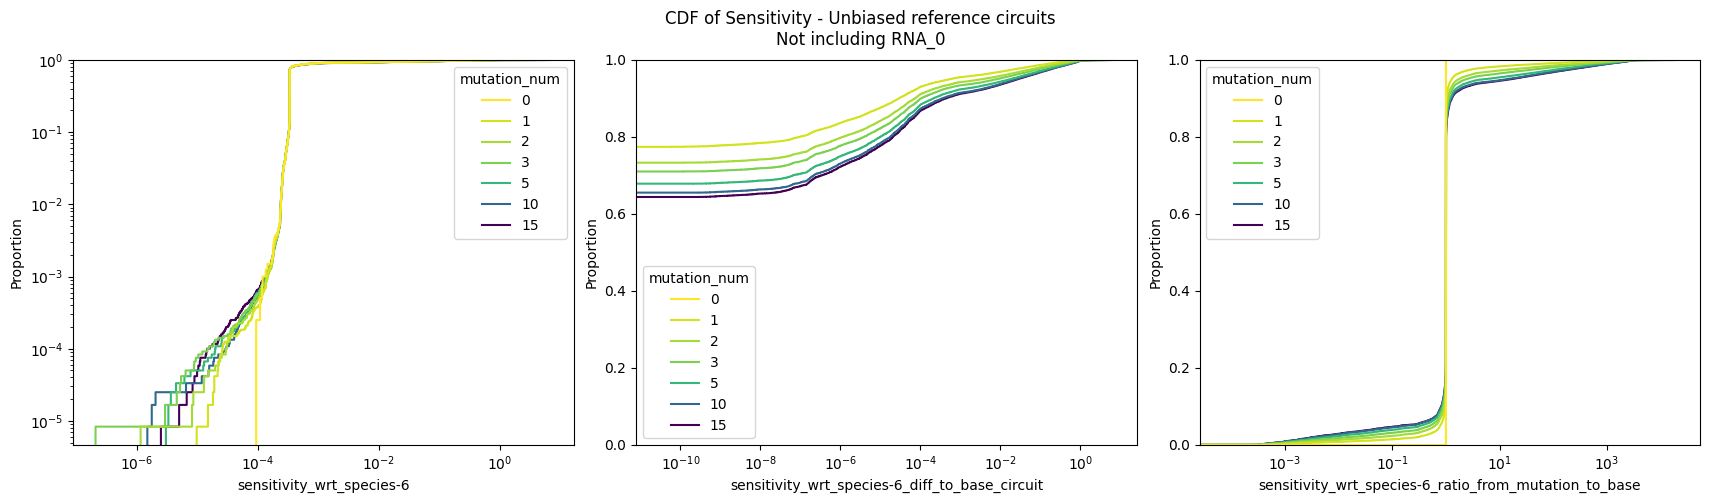

In [7]:

fig = plt.figure(figsize=(21, 5))
fig.subplots_adjust(hspace=0.125, wspace=0.125)

ax = plt.subplot(1,3,1)
sns.ecdfplot(data_rnd[data_rnd['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6', hue='mutation_num', log_scale=[True, True], palette='viridis_r')
ax = plt.subplot(1,3,2)
sns.ecdfplot(data_rnd[data_rnd['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6_diff_to_base_circuit', hue='mutation_num', log_scale=[True, False], palette='viridis_r')
ax = plt.subplot(1,3,3)
sns.ecdfplot(data_rnd[data_rnd['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6_ratio_from_mutation_to_base', hue='mutation_num', log_scale=[True, False], palette='viridis_r')

plt.suptitle('CDF of Sensitivity - Unbiased reference circuits\nNot including RNA_0')

<AxesSubplot: xlabel='binding_rates_dissociation', ylabel='Count'>

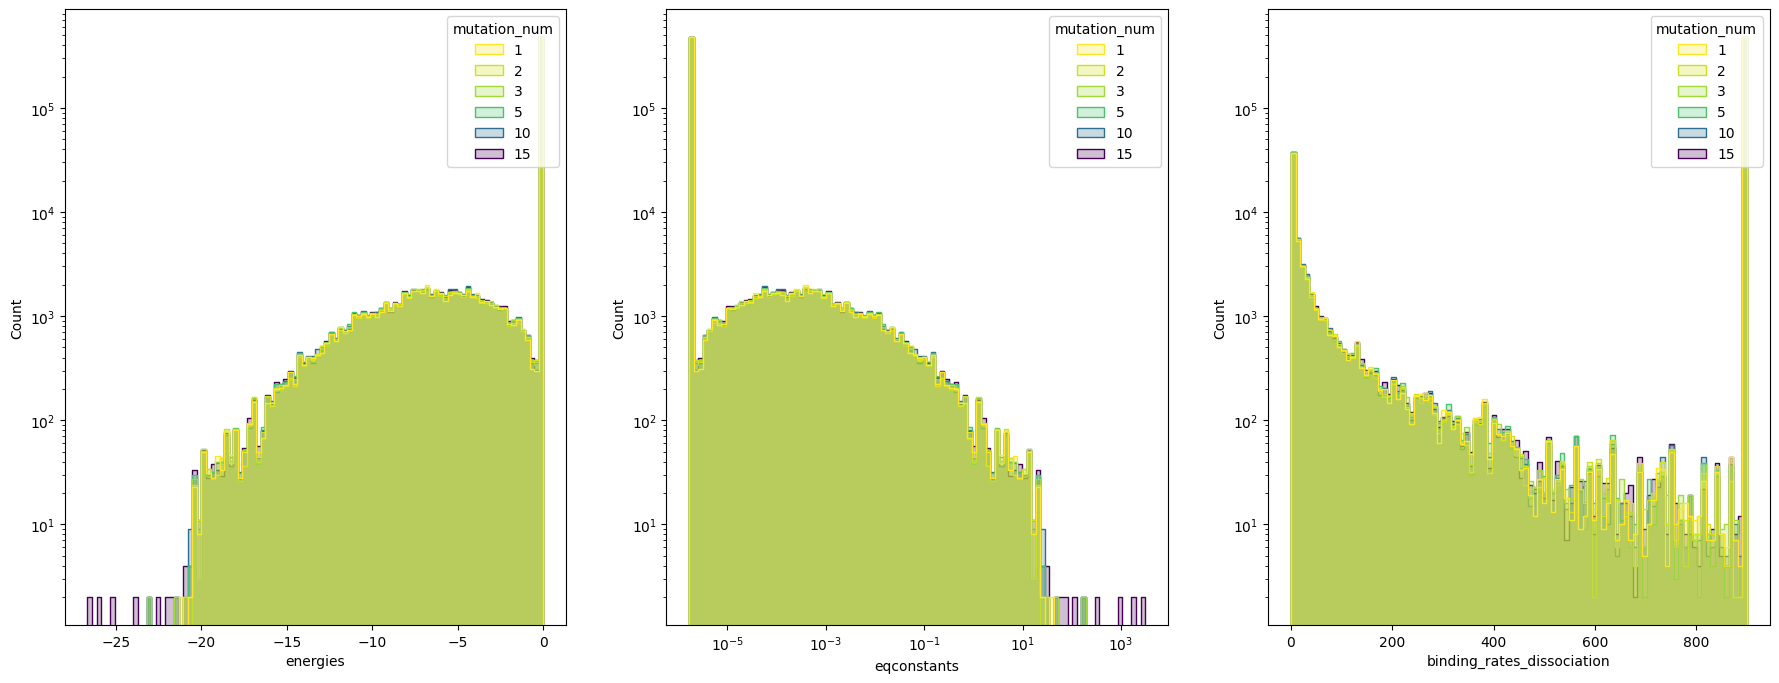

In [8]:

plt.figure(figsize=(22, 8))
ax = plt.subplot(1,3,1)
sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] > 0], x='energies', hue='mutation_num', log_scale=[False, True], element='step', bins=100, palette='viridis_r')
ax = plt.subplot(1,3,2)
sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] > 0], x='eqconstants', hue='mutation_num', log_scale=[True, True], element='step', bins=100, palette='viridis_r')
ax = plt.subplot(1,3,3)
sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] > 0], x='binding_rates_dissociation', hue='mutation_num', log_scale=[False, True], element='step', bins=100, palette='viridis_r')


### Investigate gain of interaction mutations

For some reason there's a weird ranking in the mutation numbers

In [9]:
low_circs = dfm[(dfm['num_interacting'] == 2) & (dfm['num_self_interacting'] == 1) & (dfm['mutation_num'] == 0)]['circuit_name'].unique()

gain_dfm = dfm[dfm['circuit_name'].isin(low_circs) & (dfm['mutation_num'] > 0) & (dfm['num_interacting'] >= 2) & (dfm['num_self_interacting'] >= 1)]

Text(0.5, 1.0, 'Unbiased reference circuits')

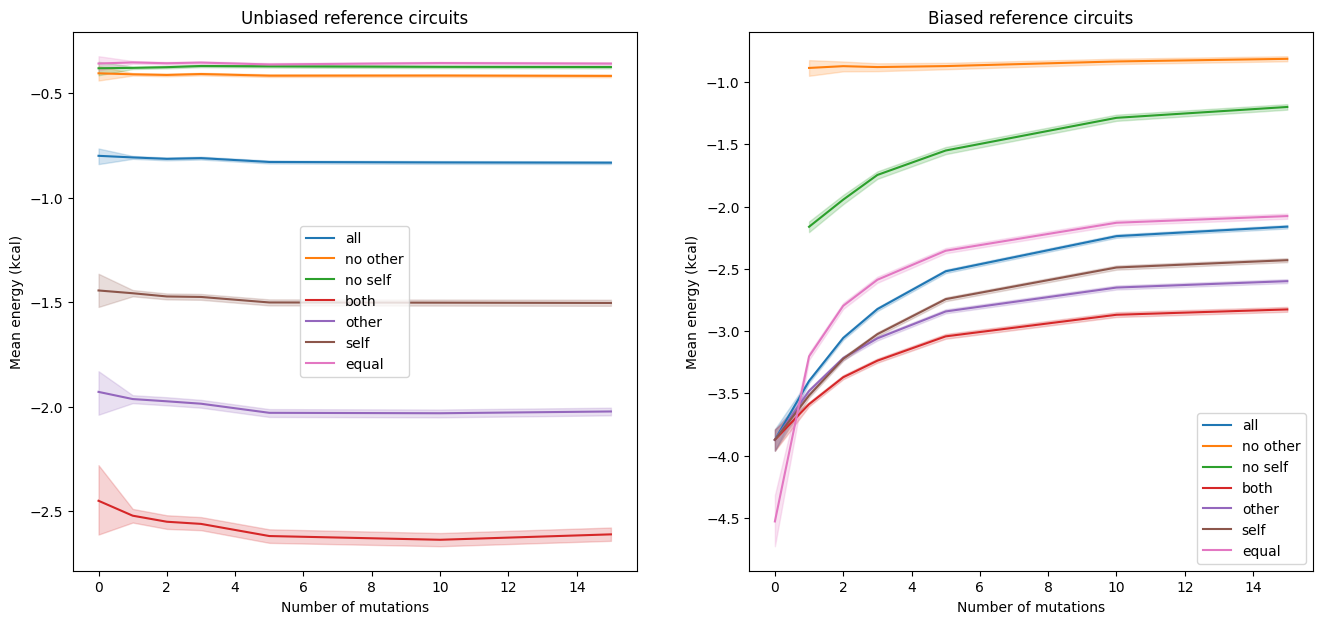

In [10]:
m = dfm # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_no_other = dfm[dfm['num_interacting'] == 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_no_self = dfm[dfm['num_self_interacting'] == 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_both = dfm[(dfm['num_interacting'] > 0) & (dfm['num_self_interacting'] > 0)] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_other = dfm[dfm['num_interacting'] > 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_self = dfm[dfm['num_self_interacting'] > 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_equal = dfm[dfm['num_self_interacting'] == dfm['num_interacting']] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})

plt.figure(figsize=(16, 7))
ax = plt.subplot(1,2,2)
sns.lineplot(m, x='mutation_num', y='energies', label='all')
sns.lineplot(m_no_other, x='mutation_num', y='energies', label='no other')
sns.lineplot(m_no_self, x='mutation_num', y='energies', label='no self')
sns.lineplot(m_both, x='mutation_num', y='energies', label='both')
sns.lineplot(m_other, x='mutation_num', y='energies', label='other')
sns.lineplot(m_self, x='mutation_num', y='energies', label='self')
sns.lineplot(m_equal, x='mutation_num', y='energies', label='equal')

plt.xlabel('Number of mutations')
plt.ylabel('Mean energy (kcal)')
plt.title('Biased reference circuits')


m = dfm_rnd # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_no_other = dfm_rnd[dfm_rnd['num_interacting'] == 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_no_self = dfm_rnd[dfm_rnd['num_self_interacting'] == 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_both = dfm_rnd[(dfm_rnd['num_interacting'] > 0) & (dfm_rnd['num_self_interacting'] > 0)] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_other = dfm_rnd[dfm_rnd['num_interacting'] > 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_self = dfm_rnd[dfm_rnd['num_self_interacting'] > 0] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_equal = dfm_rnd[dfm_rnd['num_self_interacting'] == dfm_rnd['num_interacting']] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})

ax = plt.subplot(1,2,1)
sns.lineplot(m, x='mutation_num', y='energies', label='all')
sns.lineplot(m_no_other, x='mutation_num', y='energies', label='no other')
sns.lineplot(m_no_self, x='mutation_num', y='energies', label='no self')
sns.lineplot(m_both, x='mutation_num', y='energies', label='both')
sns.lineplot(m_other, x='mutation_num', y='energies', label='other')
sns.lineplot(m_self, x='mutation_num', y='energies', label='self')
sns.lineplot(m_equal, x='mutation_num', y='energies', label='equal')

plt.xlabel('Number of mutations')
plt.ylabel('Mean energy (kcal)')
plt.title('Unbiased reference circuits')

/tmp/ipykernel_95965/3451690607.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] != 0][dfm_rnd['num_interacting'] == 0], x='energies', log_scale=[False, True], element='step', bins=50, fill=False, hue='mutation_num', palette='viridis_r')
/tmp/ipykernel_95965/3451690607.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] != 0][dfm_rnd['num_self_interacting'] == 0], x='energies', log_scale=[False, True], element='step', bins=50, fill=False, hue='mutation_num', palette='viridis_r')
/tmp/ipykernel_95965/3451690607.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] != 0][(dfm_rnd['num_interacting'] > 0) & (dfm_rnd['num_self_interacting'] > 0)], x='energies', log_scale=[False, True], element='step', bins=50, fill=False, hue='mutation_num', palette='viridis_r

Text(0.5, 1.0, 'm_equal, total: 1746918')

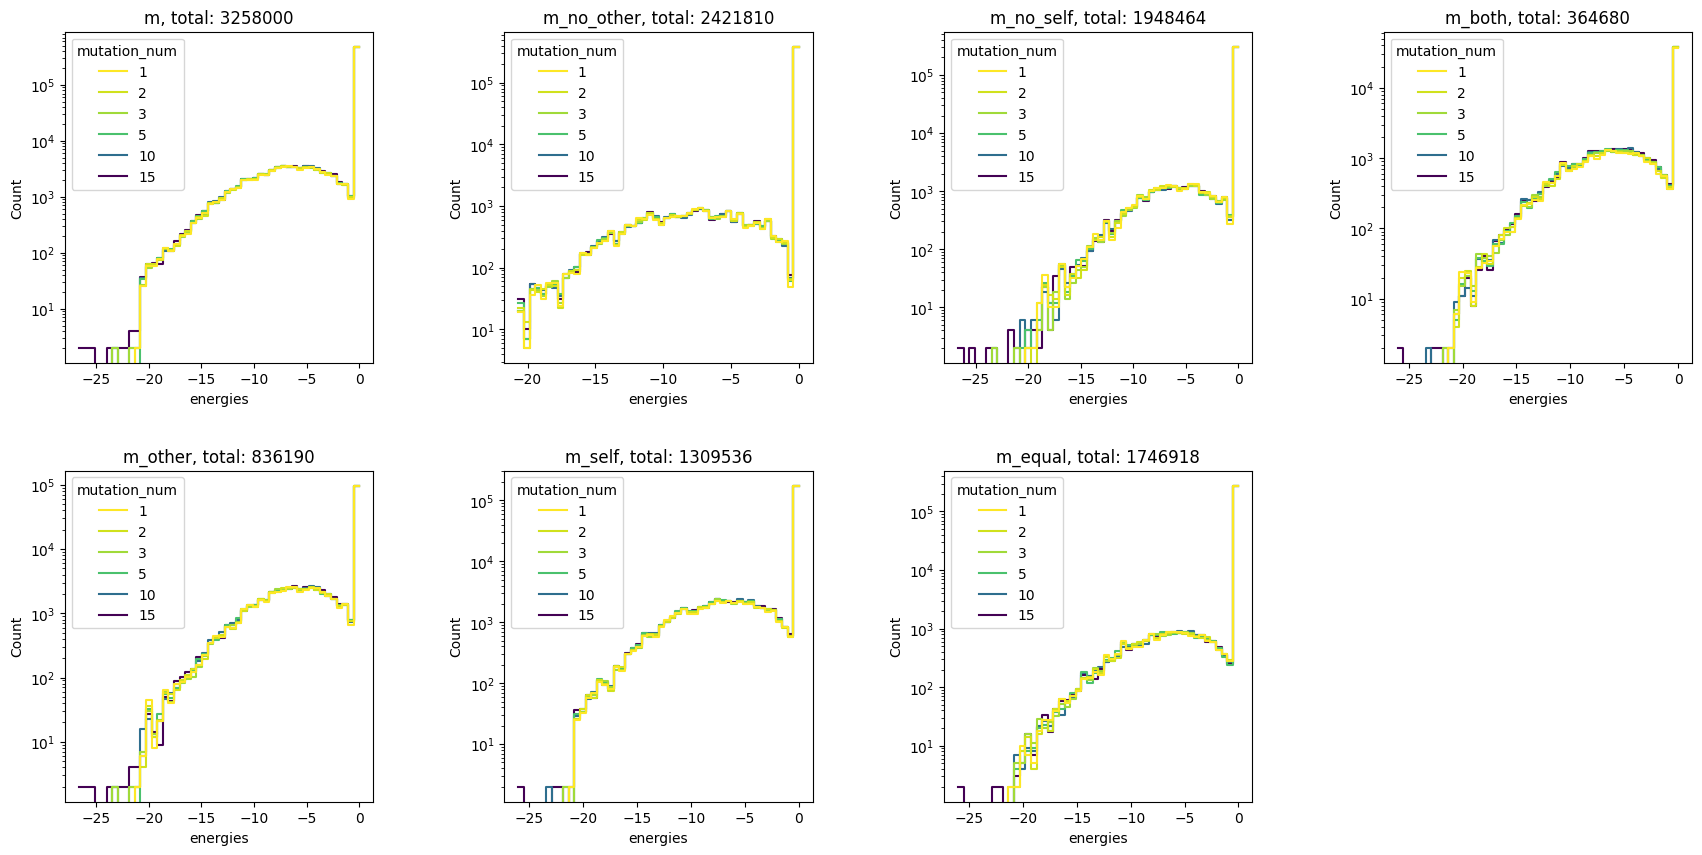

In [39]:
fig = plt.figure(figsize=(21, 10))
fig.subplots_adjust(hspace=0.325, wspace=0.425)

i = 1
ax = plt.subplot(2, 4, i)
sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] != 0], x='energies', log_scale=[False, True], element='step', bins=50, fill=False, hue='mutation_num', palette='viridis_r')
plt.title('m' + ', total: ' + str(len(dfm_rnd)))
i+=1
ax = plt.subplot(2, 4, i)
sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] != 0][dfm_rnd['num_interacting'] == 0], x='energies', log_scale=[False, True], element='step', bins=50, fill=False, hue='mutation_num', palette='viridis_r')
plt.title('m_no_other' + ', total: ' + str(len(dfm_rnd[dfm_rnd['num_interacting'] == 0])))
i+=1
ax = plt.subplot(2, 4, i)
sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] != 0][dfm_rnd['num_self_interacting'] == 0], x='energies', log_scale=[False, True], element='step', bins=50, fill=False, hue='mutation_num', palette='viridis_r')
plt.title('m_no_self' + ', total: ' + str(len(dfm_rnd[dfm_rnd['num_self_interacting'] == 0])))
i+=1
ax = plt.subplot(2, 4, i)
sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] != 0][(dfm_rnd['num_interacting'] > 0) & (dfm_rnd['num_self_interacting'] > 0)], x='energies', log_scale=[False, True], element='step', bins=50, fill=False, hue='mutation_num', palette='viridis_r')
plt.title('m_both' + ', total: ' + str(len(dfm_rnd[(dfm_rnd['num_interacting'] > 0) & (dfm_rnd['num_self_interacting'] > 0)])))
i+=1
ax = plt.subplot(2, 4, i)
sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] != 0][dfm_rnd['num_interacting'] > 0], x='energies', log_scale=[False, True], element='step', bins=50, fill=False, hue='mutation_num', palette='viridis_r')
plt.title('m_other' + ', total: ' + str(len(dfm_rnd[dfm_rnd['num_interacting'] > 0])))
i+=1
ax = plt.subplot(2, 4, i)
sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] != 0][dfm_rnd['num_self_interacting'] > 0], x='energies', log_scale=[False, True], element='step', bins=50, fill=False, hue='mutation_num', palette='viridis_r')
plt.title('m_self' + ', total: ' + str(len(dfm_rnd[dfm_rnd['num_self_interacting'] > 0])))
i+=1
ax = plt.subplot(2, 4, i)
sns.histplot(dfm_rnd[dfm_rnd['mutation_num'] != 0][dfm_rnd['num_self_interacting'] == dfm_rnd['num_interacting']], x='energies', log_scale=[False, True], element='step', bins=50, fill=False, hue='mutation_num', palette='viridis_r')
plt.title('m_equal' + ', total: ' + str(len(dfm_rnd[dfm_rnd['num_self_interacting'] == dfm_rnd['num_interacting']])))


Text(0.5, 0.98, 'Gain of interactions upon mutation: Biased starting circuits')

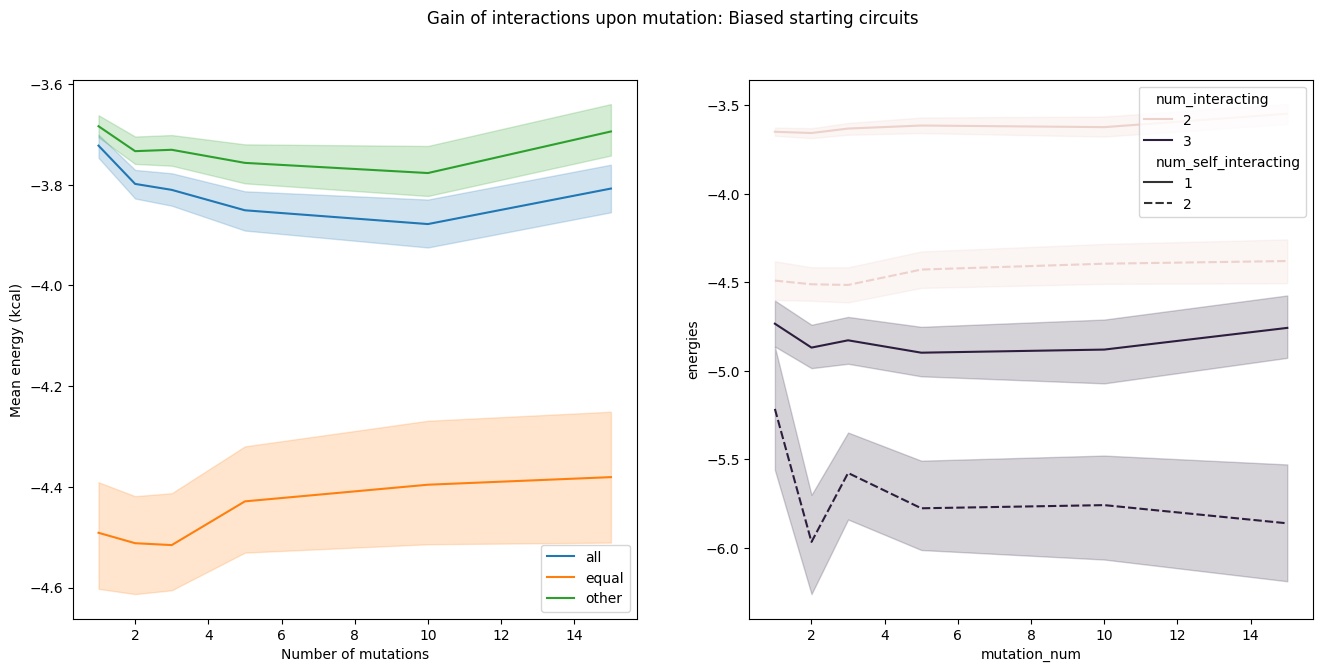

In [12]:
m = gain_dfm #.groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_equal = gain_dfm[gain_dfm['num_interacting'] == gain_dfm['num_self_interacting']] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_other = gain_dfm[gain_dfm['num_interacting'] > gain_dfm['num_self_interacting']] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})
m_self = gain_dfm[gain_dfm['num_self_interacting'] > gain_dfm['num_interacting']] # .groupby(['mutation_num'], as_index=False).agg({'energies': 'mean'})


plt.figure(figsize=(16,7))
ax = plt.subplot(1,2,1)
sns.lineplot(m, x='mutation_num', y='energies', label='all')
sns.lineplot(m_equal, x='mutation_num', y='energies', label='equal')
sns.lineplot(m_other, x='mutation_num', y='energies', label='other')
sns.lineplot(m_self, x='mutation_num', y='energies', label='self')

plt.xlabel('Number of mutations')
plt.ylabel('Mean energy (kcal)')

ax = plt.subplot(1,2,2)
# m = gain_dfm.groupby(['mutation_num', 'num_interacting', 'num_self_interacting'], as_index=False).agg({'energies': 'mean'})
sns.lineplot(m, x='mutation_num', y='energies', hue='num_interacting', style='num_self_interacting')

plt.suptitle('Gain of interactions upon mutation: Biased starting circuits')


Above, the mean interaction energies of circuits that have had a gain in interactions are plotted. A gain in interactions just means that a circuit that originally had a low number of interacting RNAs mutated and gained in the number of other/self-interacting species. 

In [13]:
dfm['bs_group_index'] = dfm['num_bs'].apply(lambda x: list(np.arange(len(x))))
dfm_e_bs = dfm.explode(column=['num_bs', 'bs_group_index'])

dfm_rnd['bs_group_index'] = dfm_rnd['num_bs'].apply(lambda x: list(np.arange(len(x))))
dfm_e_bs_rnd = dfm_rnd.explode(column=['num_bs', 'bs_group_index'])


### Energy change within circuits

When a circuit mutates, it is more likely to become nonfunctional than that it moves elsewhere within the functional region. This is because most circuits are nonfunctional and the functional ones are in a left-tailed bell curve in the energies domain. 

In [14]:
v = dfm_rnd.groupby(['circuit_name', 'mutation_num', 'mutation_name'], as_index=False).agg({'energies': 'sum'})
v

,circuit_name,mutation_num,mutation_name,energies
0,toy_circuit_combo0_100192,0,ref_circuit,-12.06
1,toy_circuit_combo0_100192,1,RNA_0_m1-0,-12.06
2,toy_circuit_combo0_100192,1,RNA_0_m1-1,-12.06
3,toy_circuit_combo0_100192,1,RNA_0_m1-2,-12.06
4,toy_circuit_combo0_100192,1,RNA_0_m1-3,-12.06
...,...,...,...,...
361995,toy_circuit_combo0_999765,15,RNA_2_m15-5,-11.26
361996,toy_circuit_combo0_999765,15,RNA_2_m15-6,-27.40
361997,toy_circuit_combo0_999765,15,RNA_2_m15-7,-11.26
361998,toy_circuit_combo0_999765,15,RNA_2_m15-8,-23.18


Text(0.5, 0.98, 'Sum of all energies (interaction between each species)\nwithin each individual circuit')

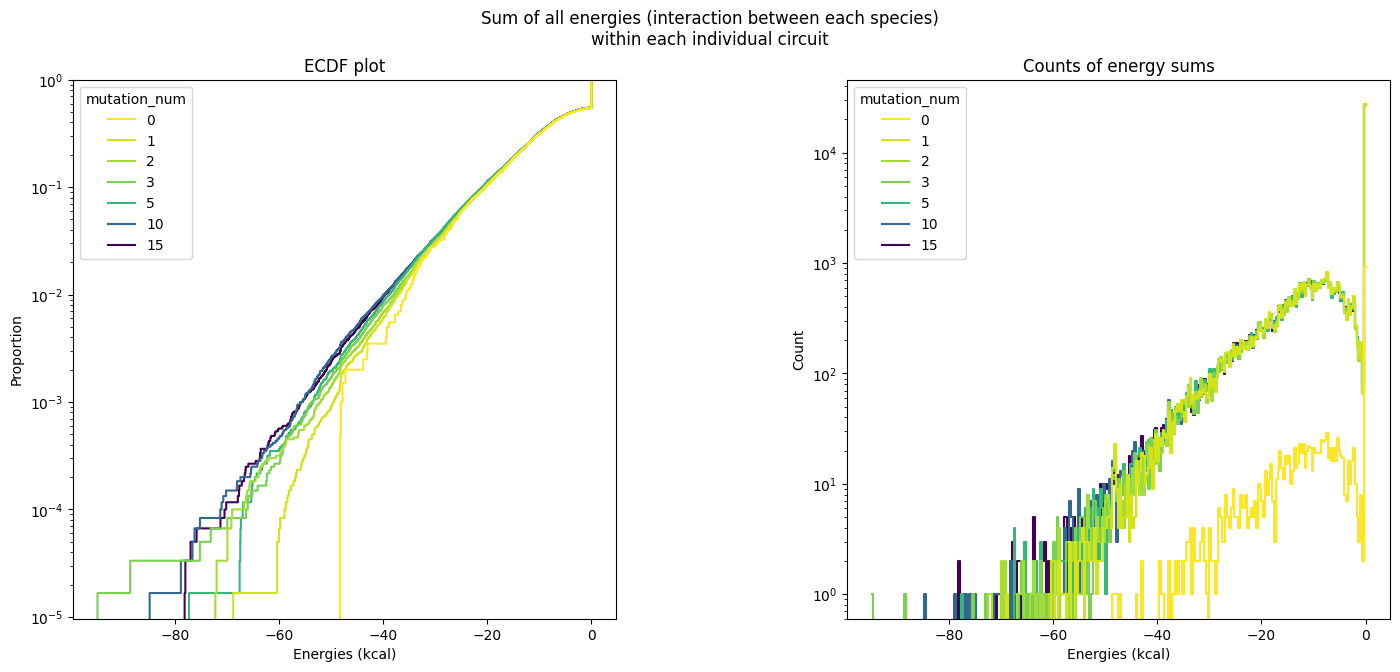

In [15]:
# Hisplot of Sum of energies within a circuit per mutation

fig = plt.figure(figsize=(17, 7))
fig.subplots_adjust(hspace=0.325, wspace=0.425)
ax = plt.subplot(1,2,1)
sns.ecdfplot(v, x='energies', hue='mutation_num', palette='viridis_r', log_scale=[False, True])
plt.xlabel('Energies (kcal)')
plt.title('ECDF plot')

ax = plt.subplot(1,2,2)
sns.histplot(v, x='energies', hue='mutation_num', element='step', palette='viridis_r', fill=False, log_scale=[False, True])
plt.xlabel('Energies (kcal)')
plt.title('Counts of energy sums')

plt.suptitle('Sum of all energies (interaction between each species)\nwithin each individual circuit')



Differences of energies: sum and individual

In [16]:
e = v.groupby(['circuit_name'], as_index=False)['energies'].transform(lambda x: x - x.loc[x[v['mutation_num'] == 0].index[0]])
e['mutation_num'] = v['mutation_num']


/tmp/ipykernel_95965/1523266114.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e = v.groupby(['circuit_name'], as_index=False)['energies'].transform(lambda x: x - x.loc[x[v['mutation_num'] == 0].index[0]])


Text(0.5, 0.98, 'Difference in sum of circuit energy between\nmutated and reference circuits')

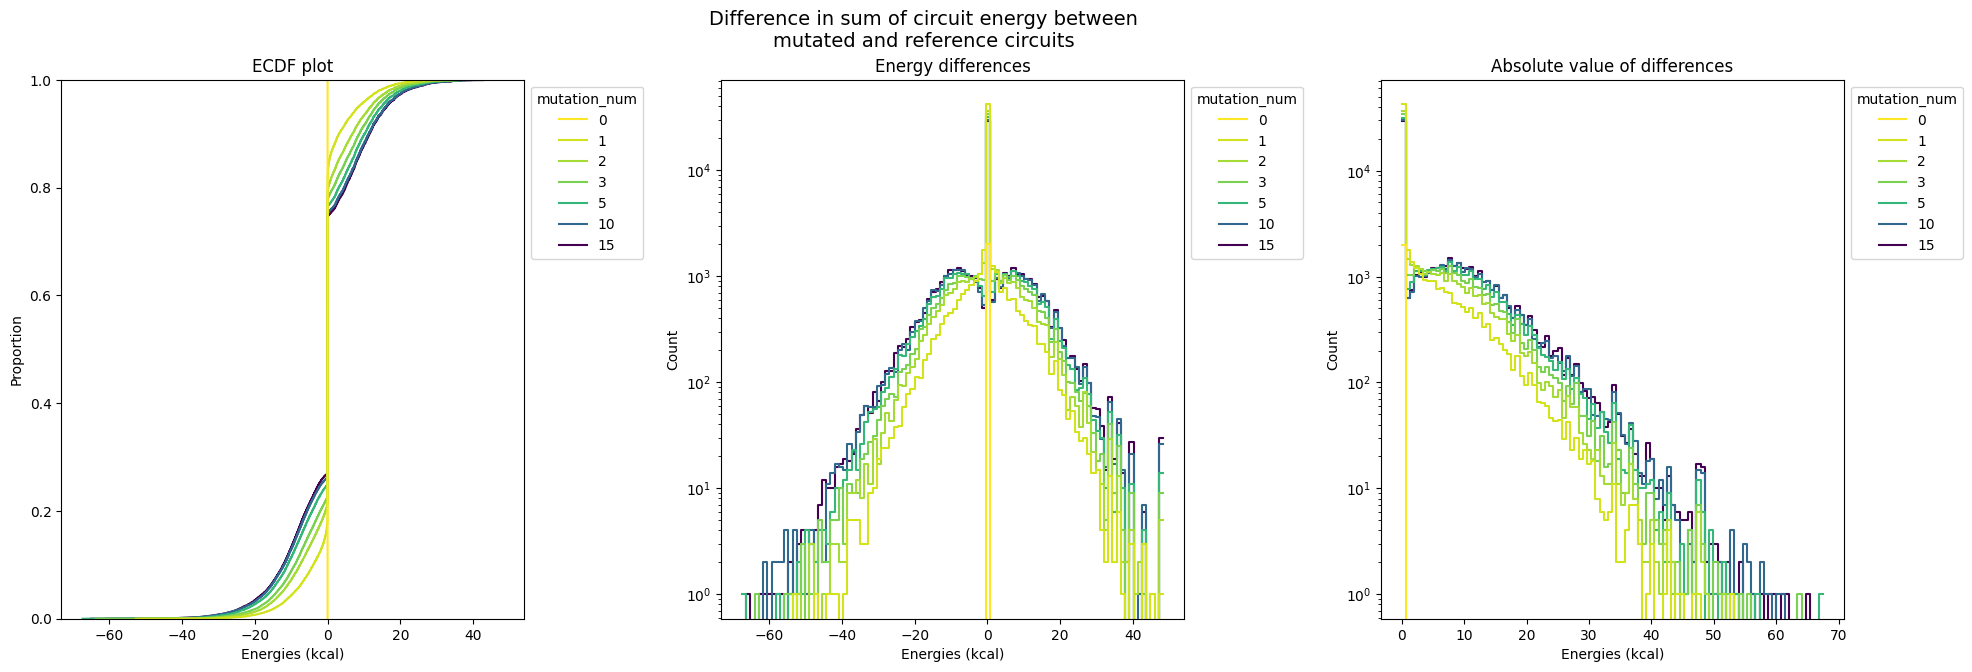

In [38]:

fig = plt.figure(figsize=(23, 7))
fig.subplots_adjust(hspace=0.375, wspace=0.425)
ax = plt.subplot(1,3,1)
sns.ecdfplot(e, x='energies', hue='mutation_num', palette='viridis_r', log_scale=[False, False])
plt.xlabel('Energies (kcal)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('ECDF plot')

ax = plt.subplot(1,3,2)
sns.histplot(e, x='energies', hue='mutation_num', element='step', palette='viridis_r', fill=False, log_scale=[False, True], bins=100)
plt.xlabel('Energies (kcal)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Energy differences')

ax = plt.subplot(1,3,3)
sns.histplot(e, x=e['energies'].abs(), hue='mutation_num', element='step', palette='viridis_r', fill=False, log_scale=[False, True], bins=100)
plt.xlabel('Energies (kcal)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Absolute value of differences')

plt.suptitle('Difference in sum of circuit energy between\nmutated and reference circuits', fontsize=14)

Differences: Individual

In [18]:
e_diffs_rnd = dfm_rnd.groupby(['circuit_name', 'idx'], as_index=False)['energies'].transform(lambda x: x - x.loc[x[dfm_rnd['mutation_num'] == 0].index[0]])
e_diffs_rnd['mutation_num'] = dfm_rnd['mutation_num']
e_diffs_rnd['energies_og'] = dfm_rnd['energies']
e_diffs_rnd['mutation_species'] = dfm_rnd['mutation_name'].str[:5]


/tmp/ipykernel_95965/3576833355.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_diffs_rnd = dfm_rnd.groupby(['circuit_name', 'idx'], as_index=False)['energies'].transform(lambda x: x - x.loc[x[dfm_rnd['mutation_num'] == 0].index[0]])


Text(0.5, 0.98, 'Difference in individual interaction energies\nbetween mutated and reference circuits')

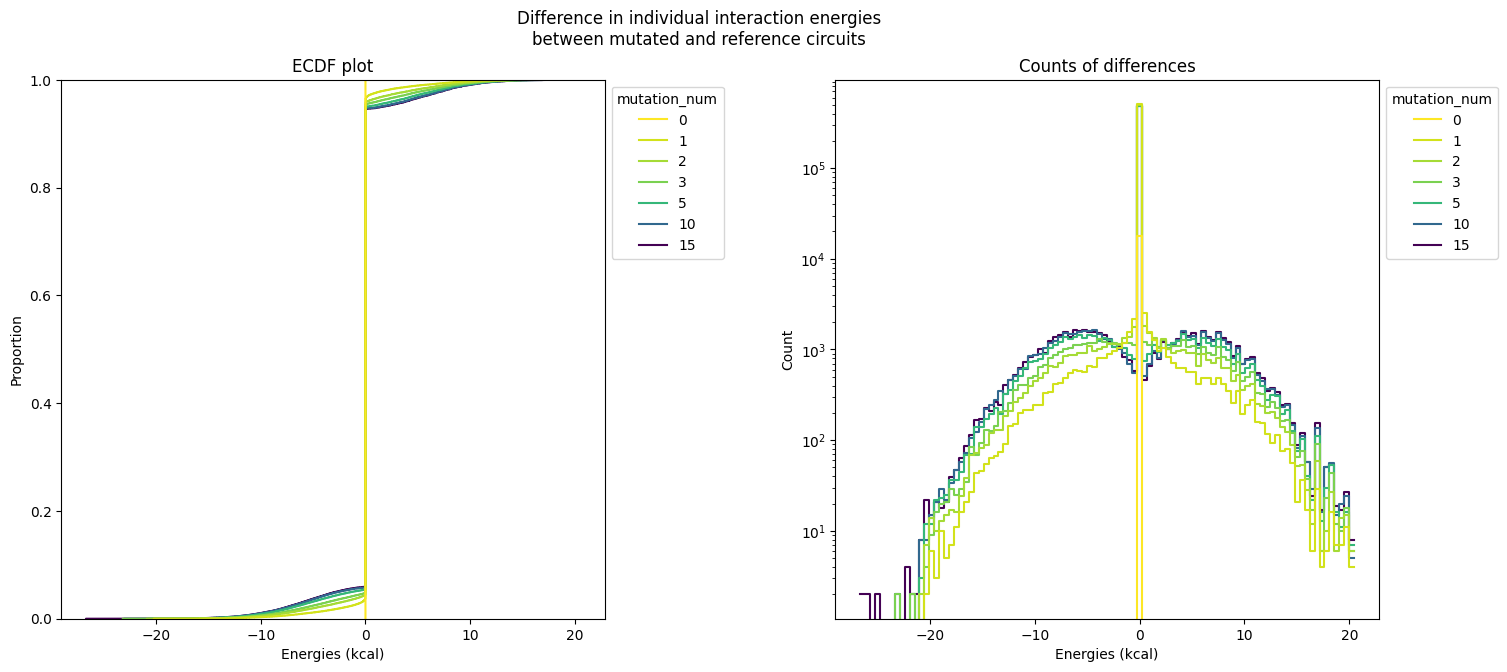

In [37]:

fig = plt.figure(figsize=(17, 7))
fig.subplots_adjust(hspace=0.325, wspace=0.425)
ax = plt.subplot(1,2,1)
sns.ecdfplot(e_diffs_rnd, x='energies', hue='mutation_num', palette='viridis_r', log_scale=[False, False])
plt.xlabel('Energies (kcal)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('ECDF plot')

ax = plt.subplot(1,2,2)
sns.histplot(e_diffs_rnd, x='energies', hue='mutation_num', element='step', palette='viridis_r', fill=False, log_scale=[False, True], bins=100)
plt.xlabel('Energies (kcal)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Counts of differences')

plt.suptitle('Difference in individual interaction energies\nbetween mutated and reference circuits')

Compare this to the biased start circuit

In [20]:
v_bias = dfm.groupby(['circuit_name', 'mutation_num', 'mutation_name'], as_index=False).agg({'energies': 'sum'})
e_bias = v_bias.groupby(['circuit_name'], as_index=False)['energies'].transform(lambda x: x - x.loc[x[v_bias['mutation_num'] == 0].index[0]])
e_bias['mutation_num'] = v_bias['mutation_num']

e_diffs = dfm.groupby(['circuit_name', 'idx'], as_index=False)['energies'].transform(lambda x: x - x.loc[x[dfm['mutation_num'] == 0].index[0]])
e_diffs['mutation_num'] = dfm['mutation_num']
e_diffs['energies_og'] = dfm['energies']



/tmp/ipykernel_95965/1119030959.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_bias = v_bias.groupby(['circuit_name'], as_index=False)['energies'].transform(lambda x: x - x.loc[x[v_bias['mutation_num'] == 0].index[0]])
/tmp/ipykernel_95965/1119030959.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_diffs = dfm.groupby(['circuit_name', 'idx'], as_index=False)['energies'].transform(lambda x: x - x.loc[x[dfm['mutation_num'] == 0].index[0]])


Text(0.5, 0.98, 'Sum of energies (interaction between each species)\nwithin each circuit: Biased starting circuits')

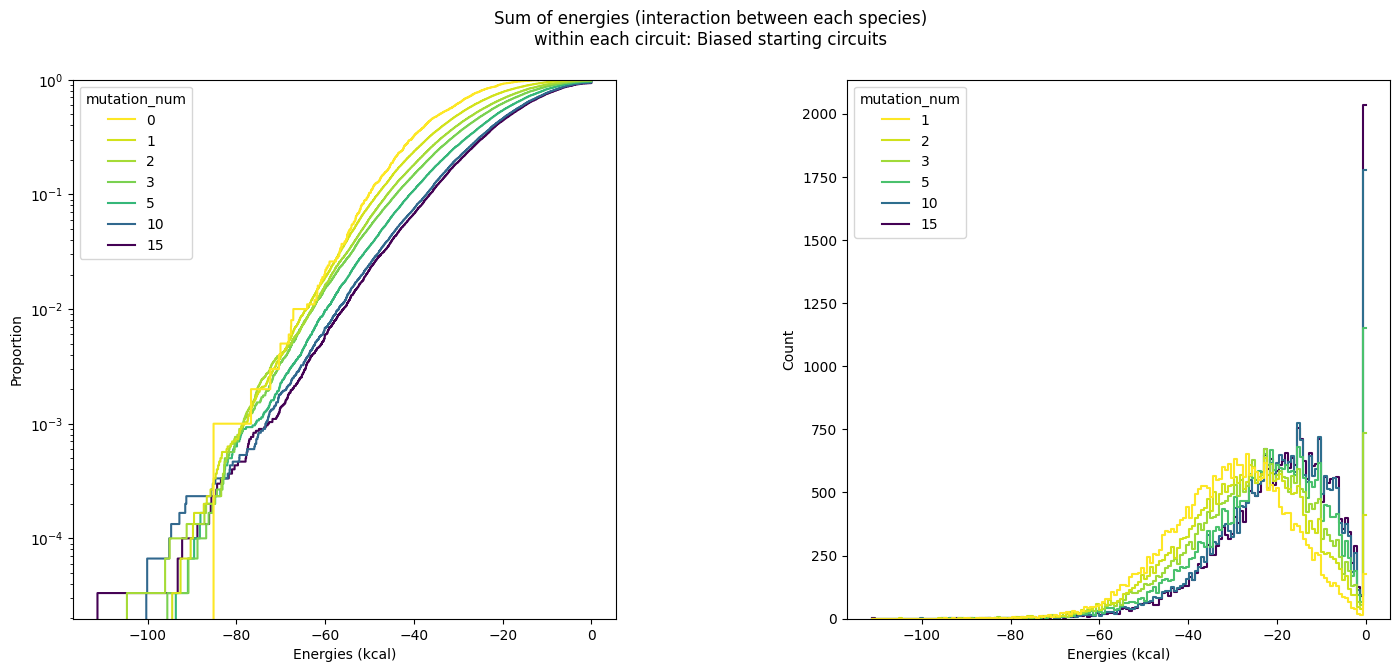

In [35]:
# Hisplot of Sum of energies within a circuit per mutation

fig = plt.figure(figsize=(17, 7))
fig.subplots_adjust(hspace=0.325, wspace=0.425)
ax = plt.subplot(1,2,1)
sns.ecdfplot(v_bias, x='energies', hue='mutation_num', palette='viridis_r', log_scale=[False, True])
plt.xlabel('Energies (kcal)')

ax = plt.subplot(1,2,2)
sns.histplot(v_bias[v_bias['mutation_num'] != 0], x='energies', hue='mutation_num', element='step', palette='viridis_r', fill=False, log_scale=[False, False])
plt.xlabel('Energies (kcal)')

plt.suptitle('Sum of energies (interaction between each species)\nwithin each circuit: Biased starting circuits')



Text(0.5, 0.98, 'Difference in sum of circuit energy between\nmutated and reference circuits: Biased starting circuits')

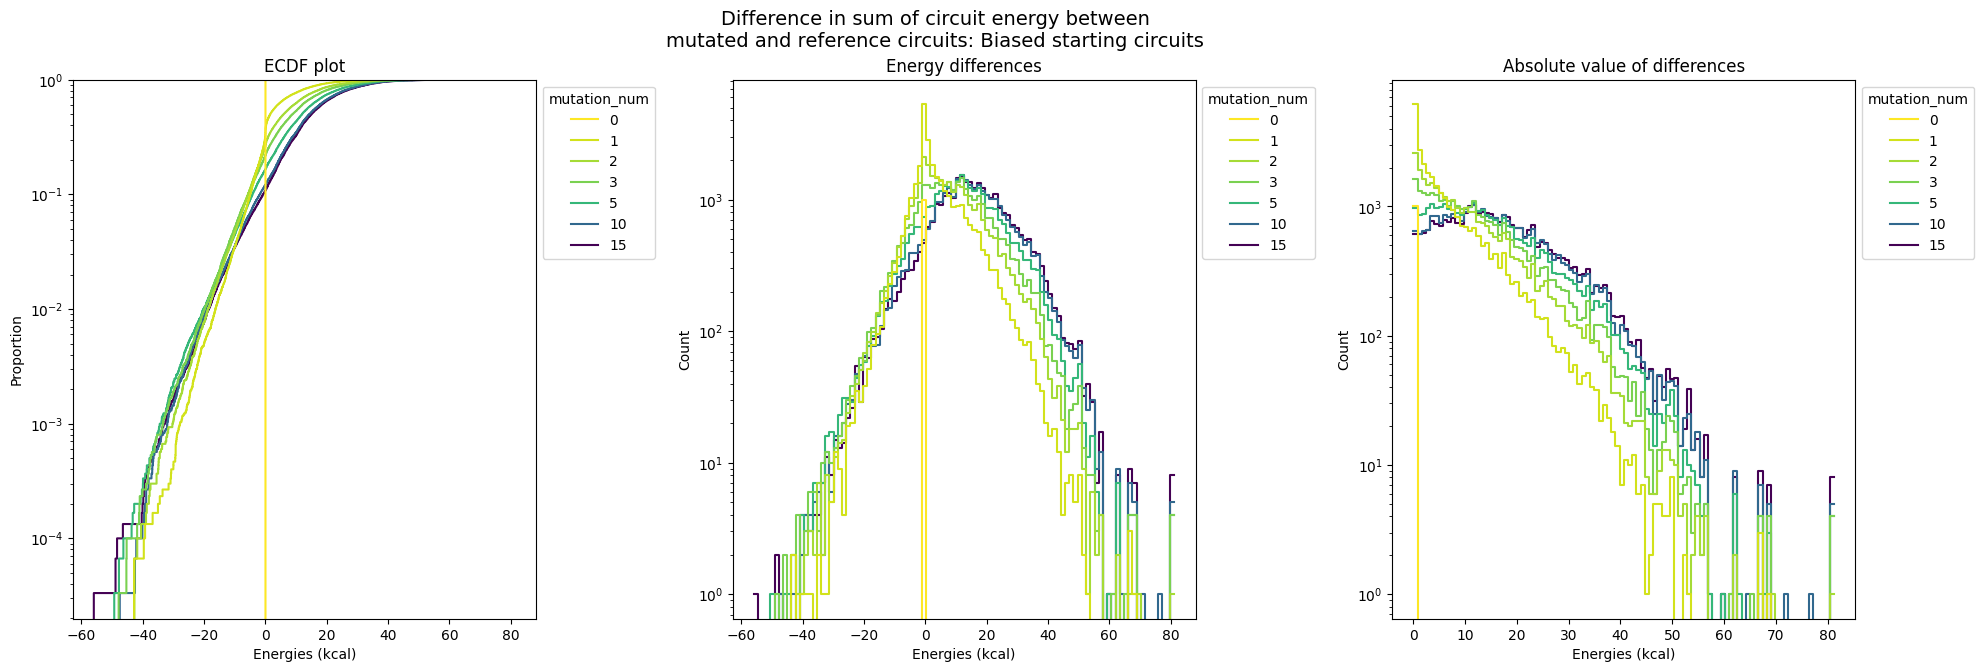

In [22]:

fig = plt.figure(figsize=(23, 7))
fig.subplots_adjust(hspace=0.375, wspace=0.425)
ax = plt.subplot(1,3,1)
sns.ecdfplot(e_bias, x='energies', hue='mutation_num', palette='viridis_r', log_scale=[False, True])
plt.xlabel('Energies (kcal)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('ECDF plot')

ax = plt.subplot(1,3,2)
sns.histplot(e_bias, x='energies', hue='mutation_num', element='step', palette='viridis_r', fill=False, log_scale=[False, True], bins=100)
plt.xlabel('Energies (kcal)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Energy differences')

ax = plt.subplot(1,3,3)
sns.histplot(e_bias, x=e_bias['energies'].abs(), hue='mutation_num', element='step', palette='viridis_r', fill=False, log_scale=[False, True], bins=100)
plt.xlabel('Energies (kcal)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Absolute value of differences')

plt.suptitle('Difference in sum of circuit energy between\nmutated and reference circuits: Biased starting circuits', fontsize=14)

Text(0.5, 0.98, 'Difference in individual interaction energies\nbetween mutated and reference circuits: Biased starting circuits')

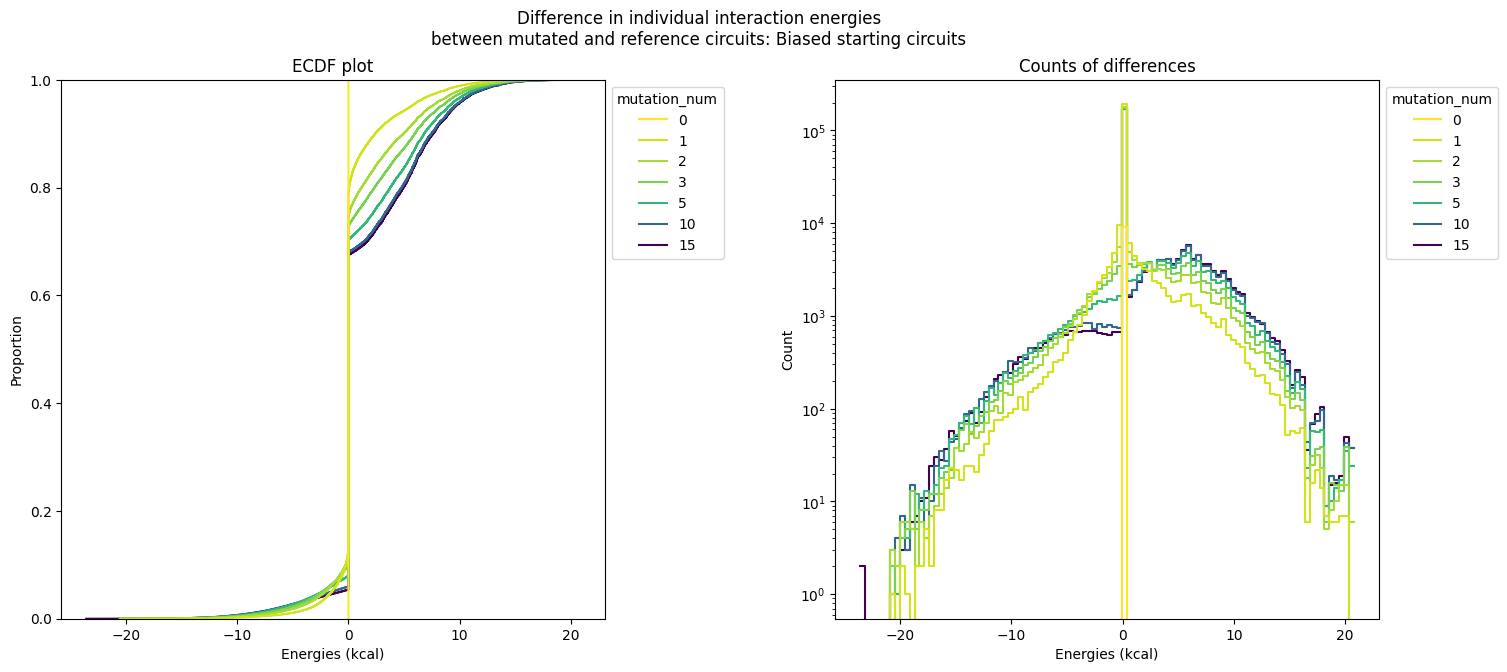

In [36]:

fig = plt.figure(figsize=(17, 7))
fig.subplots_adjust(hspace=0.325, wspace=0.425)
ax = plt.subplot(1,2,1)
sns.ecdfplot(e_diffs, x='energies', hue='mutation_num', palette='viridis_r', log_scale=[False, False])
plt.xlabel('Energies (kcal)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('ECDF plot')

ax = plt.subplot(1,2,2)
sns.histplot(e_diffs, x='energies', hue='mutation_num', element='step', palette='viridis_r', fill=False, log_scale=[False, True], bins=100)
plt.xlabel('Energies (kcal)')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Counts of differences')

plt.suptitle('Difference in individual interaction energies\nbetween mutated and reference circuits: Biased starting circuits')

### Quick comparison between the species that are mutated

In [24]:
dfm_rnd['mutation_species'] = dfm_rnd['mutation_name'].str[:5]
dfm_rnd['mutation_species']

0          ref_c
1          RNA_0
2          RNA_0
3          RNA_0
4          RNA_0
           ...  
3257995    RNA_2
3257996    RNA_2
3257997    RNA_2
3257998    RNA_2
3257999    RNA_2
Name: mutation_species, Length: 3258000, dtype: object

In [25]:
v_rnd = dfm_rnd[dfm_rnd['mutation_species'] != 'RNA_0'].groupby(['circuit_name', 'mutation_num', 'mutation_name'], as_index=False).agg({'energies': 'sum'})

e_rnd = v_rnd.groupby(['circuit_name'], as_index=False)['energies'].transform(lambda x: x - x.loc[x[v_rnd['mutation_num'] == 0].index[0]])
e_rnd['mutation_num'] = v_rnd['mutation_num']

/tmp/ipykernel_95965/3434125689.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_rnd = v_rnd.groupby(['circuit_name'], as_index=False)['energies'].transform(lambda x: x - x.loc[x[v_rnd['mutation_num'] == 0].index[0]])


In [26]:
df = dfm_rnd[dfm_rnd['mutation_species'] != 'RNA_0']
e_diffs_rnd2 = df.groupby(['circuit_name', 'idx'], as_index=False)['energies'].transform(lambda x: x - x.loc[x[df['mutation_num'] == 0].index[0]])
e_diffs_rnd2['mutation_num'] = df['mutation_num']
e_diffs_rnd2['energies_og'] = df['energies']



/tmp/ipykernel_95965/2068088325.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  e_diffs_rnd2 = df.groupby(['circuit_name', 'idx'], as_index=False)['energies'].transform(lambda x: x - x.loc[x[df['mutation_num'] == 0].index[0]])


Text(0.5, 0, 'Energy (kcal)')

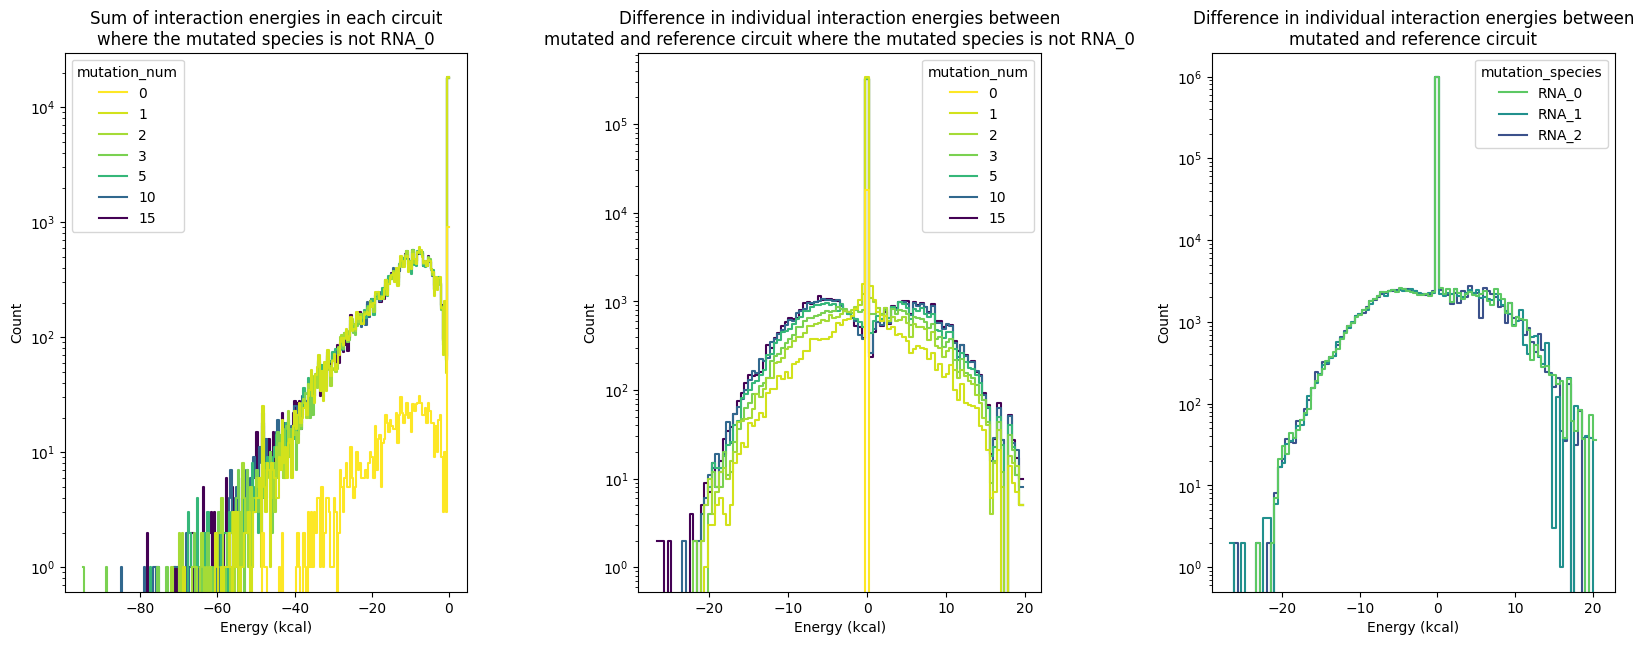

In [27]:

fig = plt.figure(figsize=(20, 7))
fig.subplots_adjust(hspace=0.325, wspace=0.425)

ax = plt.subplot(1,3,1)
sns.histplot(v_rnd, x='energies', hue='mutation_num', element='step', fill=False, palette='viridis_r', log_scale=[False, True])
plt.title('Sum of interaction energies in each circuit\nwhere the mutated species is not RNA_0')
plt.xlabel('Energy (kcal)')

ax = plt.subplot(1,3,2)
sns.histplot(e_diffs_rnd2, x='energies', hue='mutation_num', element='step', fill=False, palette='viridis_r', log_scale=[False, True], bins=100)
plt.title('Difference in individual interaction energies between\nmutated and reference circuit where the mutated species is not RNA_0')
plt.xlabel('Energy (kcal)')

ax = plt.subplot(1,3,3)
sns.histplot(e_diffs_rnd[e_diffs_rnd['mutation_species'] != 'ref_c'], x='energies', hue='mutation_species', element='step', fill=False, palette='viridis_r', log_scale=[False, True], bins=100)
plt.title('Difference in individual interaction energies between\nmutated and reference circuit')
plt.xlabel('Energy (kcal)')


## Binding site groups and number of binding sites 

Text(0.5, 0.98, 'Unbiased starting circuits')

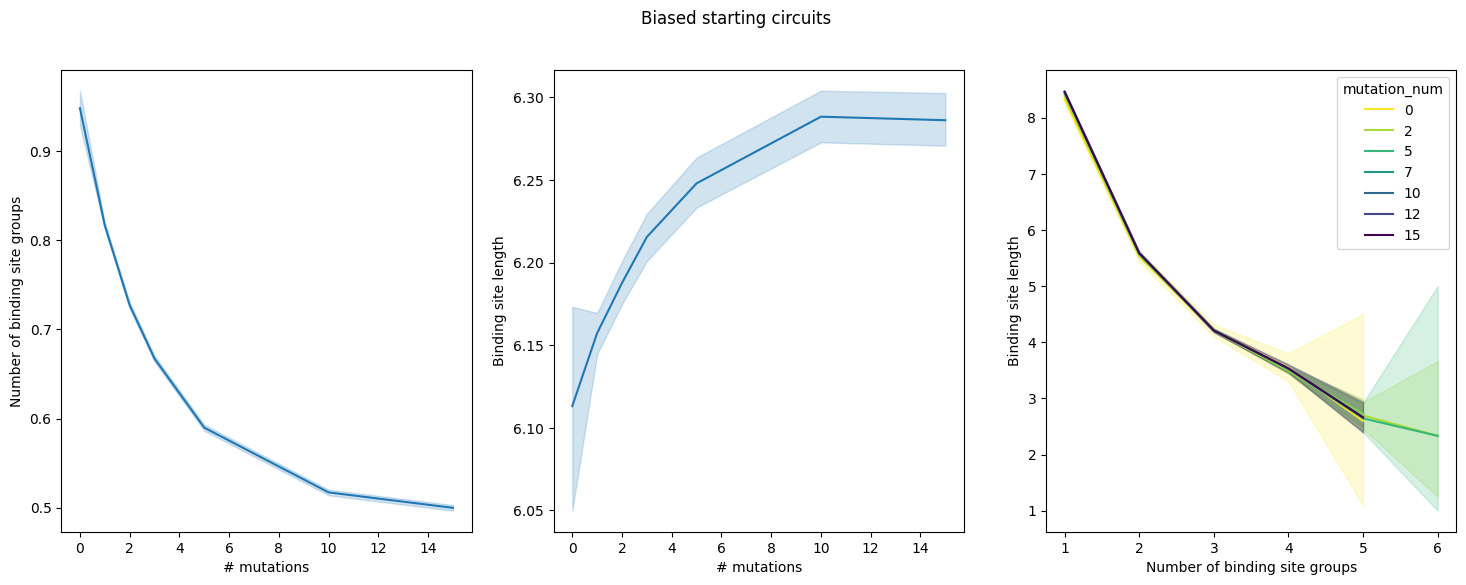

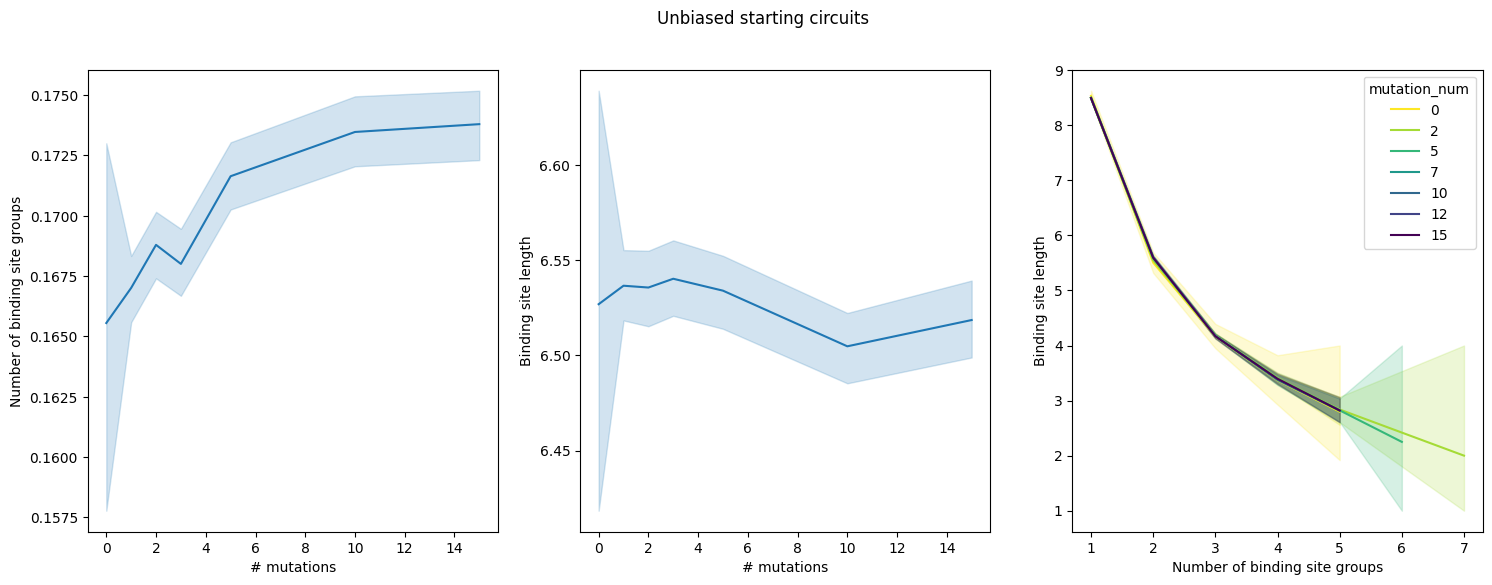

In [28]:
plt.figure(figsize=(18,6))
ax = plt.subplot(1,3,1)
sns.lineplot(dfm, x='mutation_num', y='num_groups')
plt.xlabel('# mutations')
plt.ylabel('Number of binding site groups')

ax = plt.subplot(1,3,2)
sns.lineplot(dfm_e_bs.reset_index(), x='mutation_num', y='num_bs')
plt.xlabel('# mutations')
plt.ylabel('Binding site length')

ax = plt.subplot(1,3,3)
sns.lineplot(dfm_e_bs.reset_index(), x='num_groups', y='num_bs', hue='mutation_num', palette='viridis_r')
plt.ylabel('Binding site length')
plt.xlabel('Number of binding site groups')

plt.suptitle('Biased starting circuits')


plt.figure(figsize=(18,6))
ax = plt.subplot(1,3,1)
sns.lineplot(dfm_rnd, x='mutation_num', y='num_groups')
plt.xlabel('# mutations')
plt.ylabel('Number of binding site groups')

ax = plt.subplot(1,3,2)
sns.lineplot(dfm_e_bs_rnd.reset_index(), x='mutation_num', y='num_bs')
plt.xlabel('# mutations')
plt.ylabel('Binding site length')

ax = plt.subplot(1,3,3)
sns.lineplot(dfm_e_bs_rnd.reset_index(), x='num_groups', y='num_bs', hue='mutation_num', palette='viridis_r')
plt.ylabel('Binding site length')
plt.xlabel('Number of binding site groups')

plt.suptitle('Unbiased starting circuits')




Text(0.5, 1.0, 'Mean number of binding site groups per circuit')

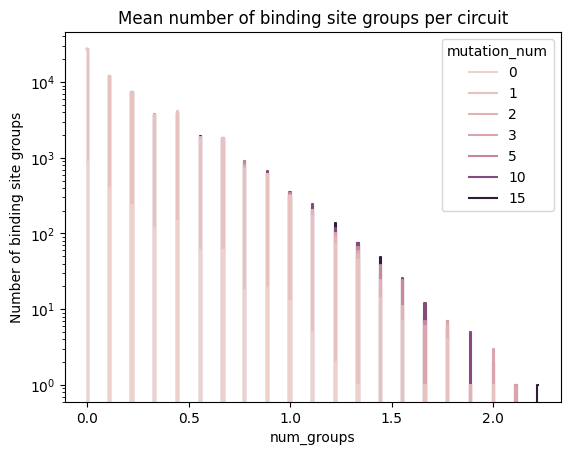

In [29]:
sns.histplot(dfm_rnd.groupby(['circuit_name', 'mutation_num', 'mutation_name'], as_index=False).agg({'num_groups': 'mean'}), x='num_groups', hue='mutation_num', element='step', fill=False, log_scale=[False, True])
plt.ylabel('Number of binding site groups')
plt.title('Mean number of binding site groups per circuit')

Text(0.5, 0.98, 'Unbiased starting circuits')

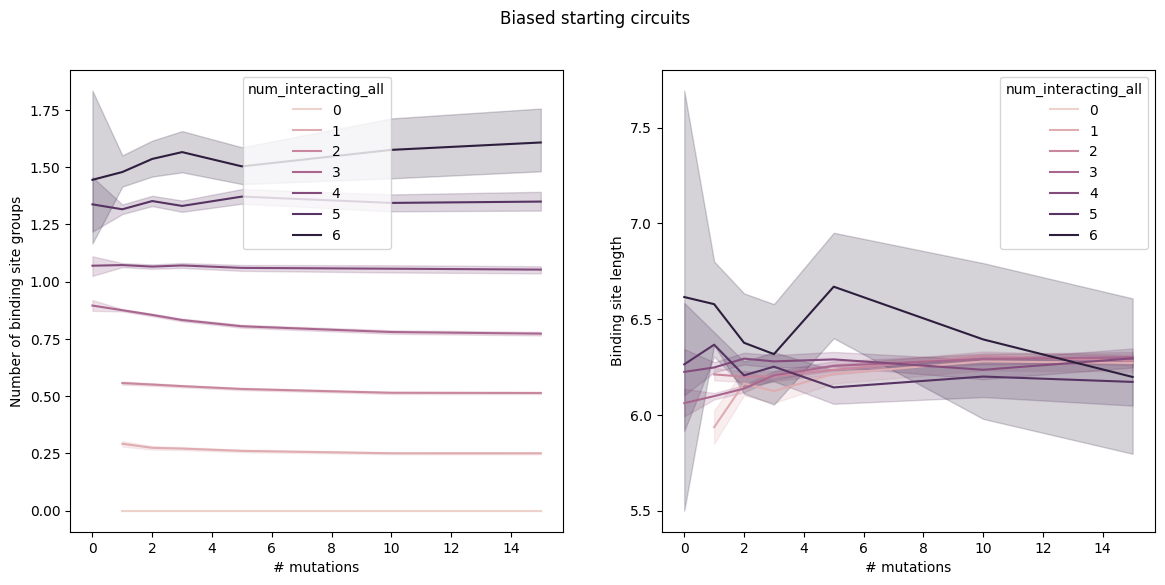

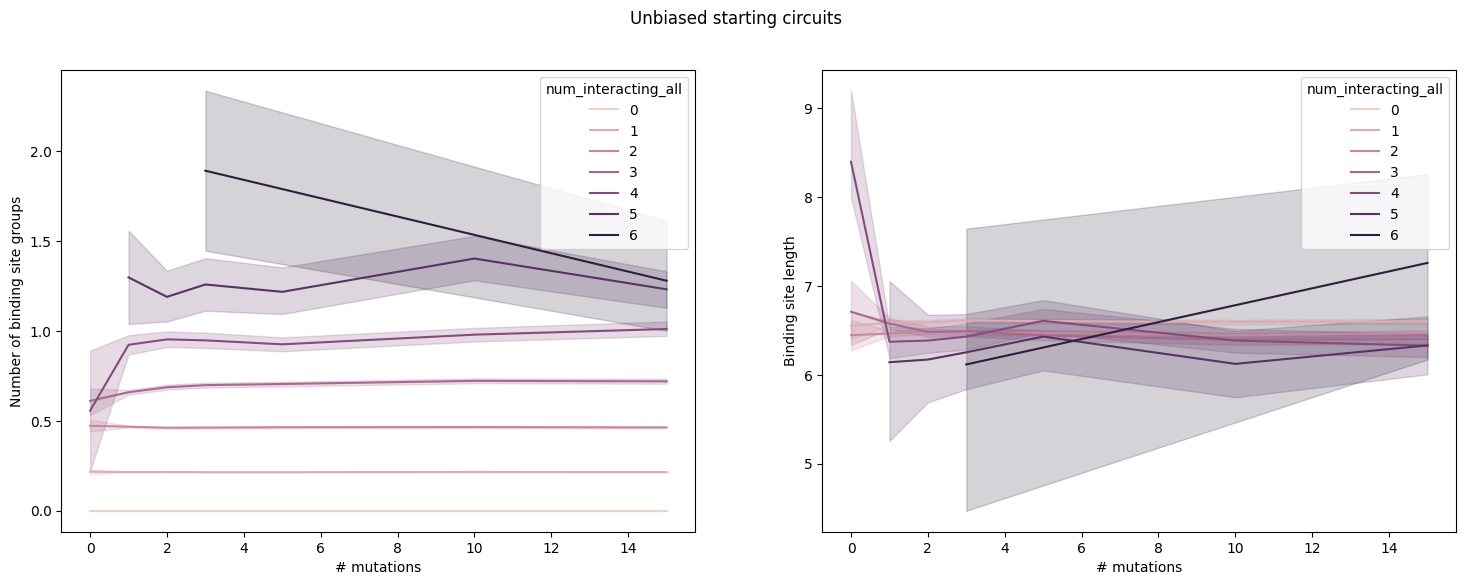

In [30]:
plt.figure(figsize=(14,6))
ax = plt.subplot(1,2,1)
sns.lineplot(dfm, x='mutation_num', y='num_groups', hue='num_interacting_all')
plt.xlabel('# mutations')
plt.ylabel('Number of binding site groups')

ax = plt.subplot(1,2,2)
sns.lineplot(dfm_e_bs.reset_index(), x='mutation_num', y='num_bs', hue='num_interacting_all')
plt.xlabel('# mutations')
plt.ylabel('Binding site length')

plt.suptitle('Biased starting circuits')


plt.figure(figsize=(18,6))
ax = plt.subplot(1,2,1)
sns.lineplot(dfm_rnd, x='mutation_num', y='num_groups', hue='num_interacting_all')
plt.xlabel('# mutations')
plt.ylabel('Number of binding site groups')

ax = plt.subplot(1,2,2)
sns.lineplot(dfm_e_bs_rnd.reset_index(), x='mutation_num', y='num_bs', hue='num_interacting_all')
plt.xlabel('# mutations')
plt.ylabel('Binding site length')

plt.suptitle('Unbiased starting circuits')


In [31]:
print('The biased circuits have the following sample numbers for each category of number of interacting species.')
dfm['num_interacting_all'].value_counts()

The biased circuits have the following sample numbers for each category of number of interacting species.


2    571743
3    545499
1    266868
4    163791
0     54135
5     25236
6      1728
Name: num_interacting_all, dtype: int64

In [32]:
print('On the other hand, the unbiased circuits have the following sample numbers for each category of\n', 
      'number of interacting species, having much lower sample numbers as the number of interacting\n',
      'samples increases compared to the circuits that were chosen in a biased manner from the offest.')
dfm_rnd['num_interacting_all'].value_counts()

On the other hand, the unbiased circuits have the following sample numbers for each category of
 number of interacting species, having much lower sample numbers as the number of interacting
 samples increases compared to the circuits that were chosen in a biased manner from the offest.


0    1476954
1    1205640
2     463401
3      99711
4      11358
5        909
6         27
Name: num_interacting_all, dtype: int64

Text(0.5, 0, 'Binding site length')

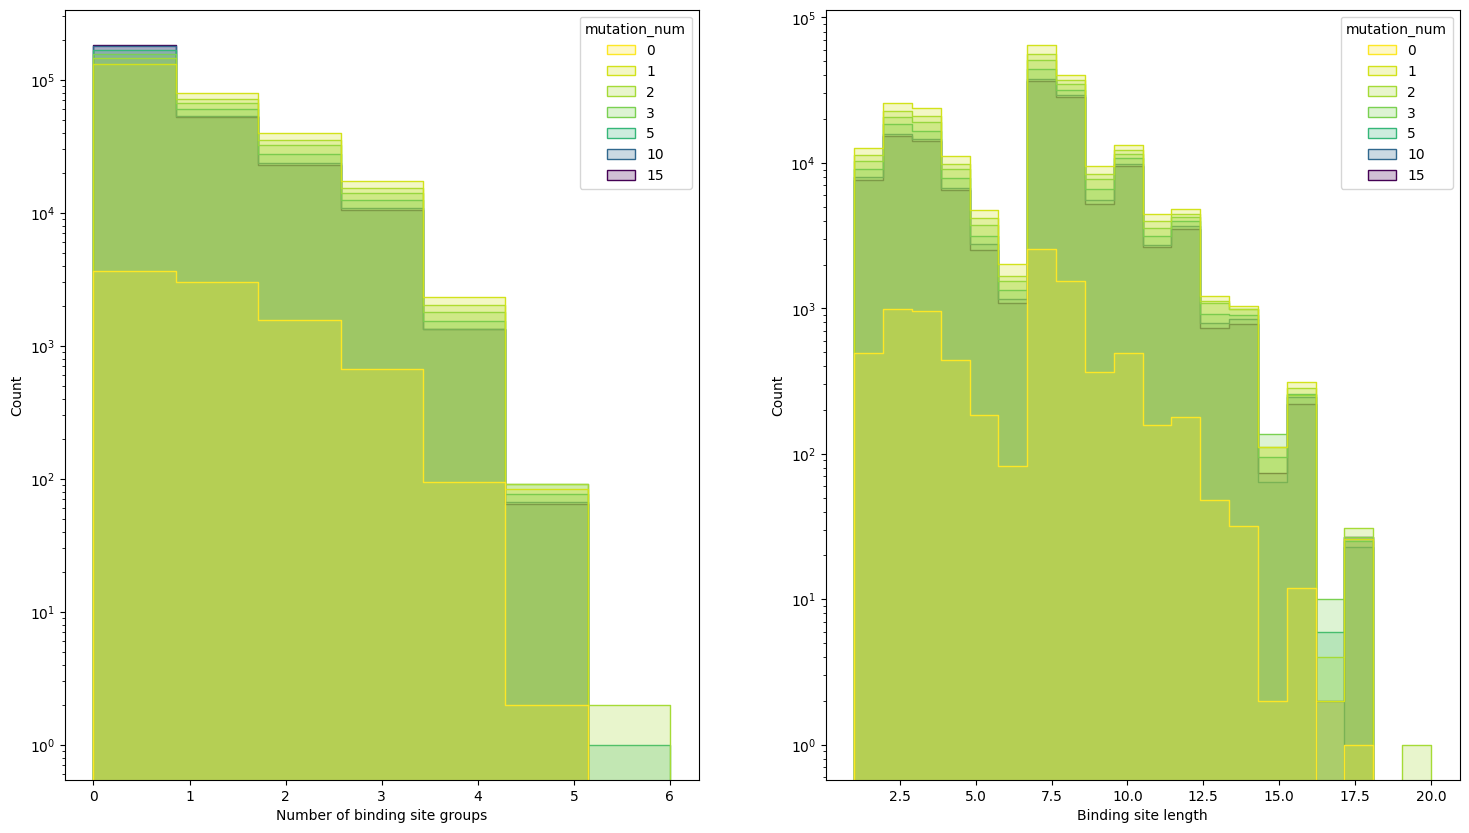

In [33]:
plt.figure(figsize=(18,10))
ax = plt.subplot(1,2,1)
sns.histplot(dfm, hue='mutation_num', x='num_groups', element='step', palette='viridis_r', bins = 7, log_scale=[False, True])
plt.xlabel('Number of binding site groups')

ax = plt.subplot(1,2,2)
sns.histplot(dfm_e_bs.reset_index(), hue='mutation_num', x='num_bs', palette='viridis_r', element='step', bins=20, log_scale=[False, True])
plt.xlabel('Binding site length')

Energy per binding site length and number of binding groups

Text(0, 0.5, 'Energies (kcal)')

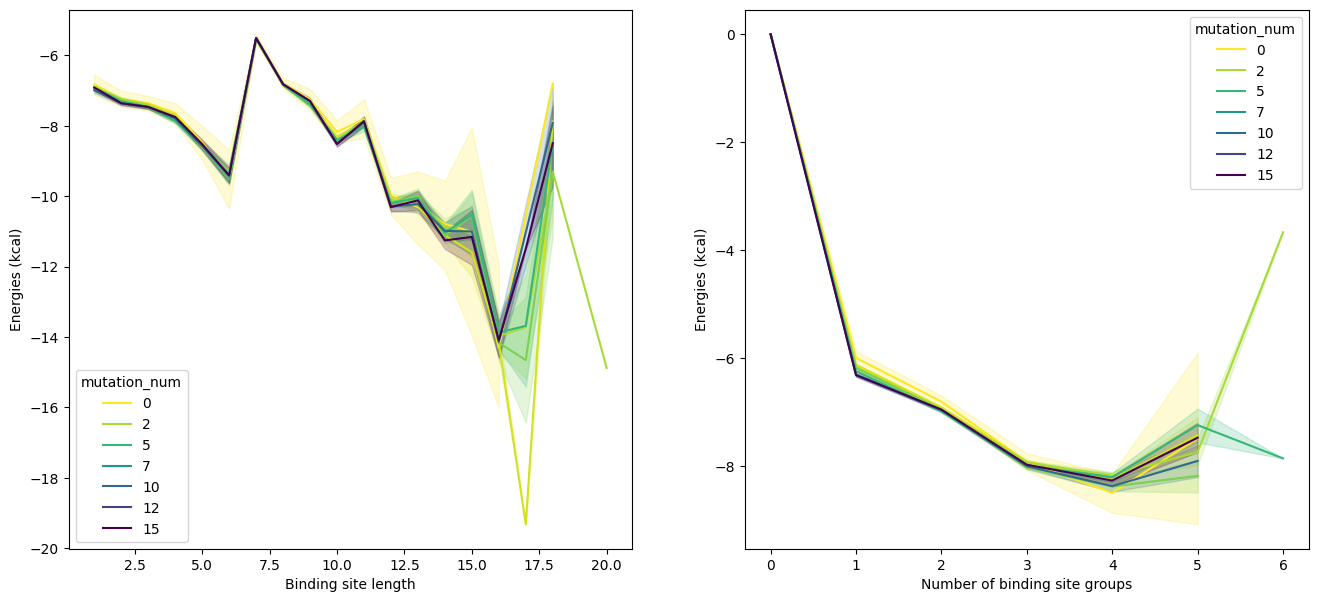

In [34]:
plt.figure(figsize=(16, 7))
ax = plt.subplot(1,2,1)
sns.lineplot(dfm_e_bs.reset_index(), x='num_bs', y='energies', hue='mutation_num', palette='viridis_r')
plt.xlabel('Binding site length')
plt.ylabel('Energies (kcal)')
ax = plt.subplot(1,2,2)
sns.lineplot(dfm_e_bs.reset_index(), x='num_groups', y='energies', hue='mutation_num', palette='viridis_r')
plt.xlabel('Number of binding site groups')
plt.ylabel('Energies (kcal)')